How did you start Notebook
--------------------------

When starting this notebook using this:
```bash
~/tutorial-env/bin/ipython notebook --pylab=inline
```
comment out the code in the following cell.

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


**Generate the data necessary to this project first.**

Generated input data is saved in: /tmp/tmpATFtD4


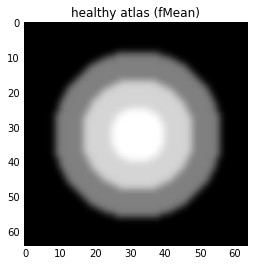

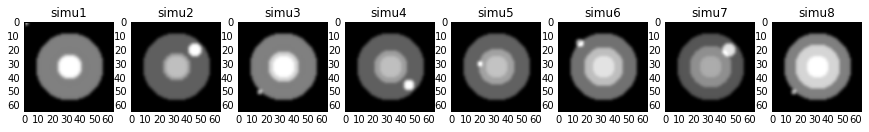

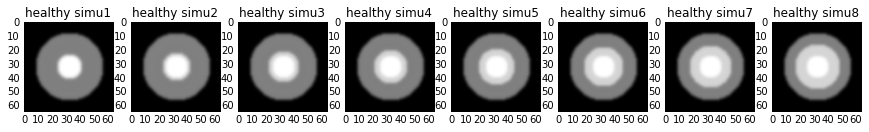

In [4]:
import tempfile
figure()
data_folder=tempfile.mkdtemp()
print "Generated input data is saved in: "+data_folder
%run ../../helper/gen_3D_simulation_data.py $data_folder

In [5]:
sys.path.append('../../')
from pyLAR import *

In [6]:
# global settings
result_folder = data_folder +'/atlas-building'
if not os.path.exists(result_folder):
    os.makedirs(result_folder)
im_names = [ \
 data_folder+'/simu1.nrrd',
 data_folder+'/simu2.nrrd',
 data_folder+'/simu3.nrrd',
 data_folder+'/simu4.nrrd']
reference_im_name = data_folder +'/fMeanSimu.nrrd'

In [7]:
# data selection and global parameters, prepare iter0 data
import shutil
selection = [0,1,2,3]    
num_of_data = len(selection)  
for i in range(num_of_data):
    iter0fn = result_folder+'/Iter0'+ '_simu_' + str(i)  + '.nrrd'
    simufn = im_names[selection[i]]
    shutil.copy(simufn, iter0fn)

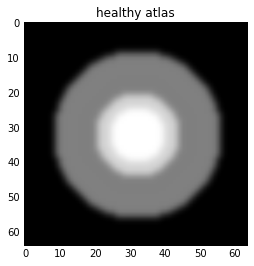

In [8]:
# profile data size, save into global variables
im_ref = sitk.ReadImage(reference_im_name) # image in SITK format
im_ref_array = sitk.GetArrayFromImage(im_ref) # get numpy array
z_dim, x_dim, y_dim = im_ref_array.shape # get 3D volume shape
vector_length = z_dim*x_dim*y_dim

figure()
implot = imshow(im_ref_array[32,:,:],cm.gray)
plt.title('healthy atlas')

slice_nr = 32  # just for vis purpose

Replace executable paths in the following cell
----------------------------------------------

In [9]:
AverageImagesExecutable = '/home/fbudin/Tools/ANTs.2.1.0.Debian-Ubuntu_X64/AverageImages'
EXE_BRAINSDemonWarp = '/home/fbudin/Tools/Slicer-4.5.0-1-linux-amd64/Slicer --launch /home/fbudin/Tools/Slicer-4.5.0-1-linux-amd64/lib/Slicer-4.5/cli-modules/BRAINSDemonWarp'
EXE_ComposeMultiTransform = '/home/fbudin/Tools/ANTs.2.1.0.Debian-Ubuntu_X64/ComposeMultiTransform'
EXE_BRAINSResample = '/home/fbudin/Tools/Slicer-4.5.0-1-linux-amd64/Slicer --launch /home/fbudin/Tools/Slicer-4.5.0-1-linux-amd64/lib/Slicer-4.5/cli-modules/BRAINSResample'

In [10]:
###############################  the main pipeline #############################
def AverageImages(currentIter,atlasIm):
    listOfImages = []
    for i in range(num_of_data):
        movingIm = result_folder+'/'+ 'Iter'+ str(currentIter-1)+'_simu_' + str(i)  +'.nrrd'
        listOfImages.append(movingIm)
    arguments = ' 3 ' + atlasIm +'  0  ' +  ' '.join(listOfImages)
    cmd = AverageImagesExecutable + ' ' + arguments
    tempFile = open(result_folder+'/average.log', 'w')
    process = subprocess.Popen(cmd, stdout=tempFile, shell=True)
    process.wait()
    tempFile.close()
    return

def runIteration(currentIter,gridSize=[3,3,3]):
    Y = np.zeros((vector_length,num_of_data))
    for i in range(num_of_data) :
        im_file =  result_folder+'/'+ 'Iter'+str(currentIter - 1)+'_simu_' + str(i)  + '.nrrd'
        tmp = sitk.ReadImage(im_file)
        #print 'read:'+ im_file
        tmp = sitk.GetArrayFromImage(tmp)
        Y[:,i] = tmp.reshape(-1)
    
    # Visualize and inspect
    plt.figure(figsize=(15,15))
    pyLAR.showSlice(Y, 'Iter'+str(currentIter) +' Input',cm.gray,0, im_file)    
    savefig(result_folder+'/'+'Iter'+ str(currentIter)+'.png')
    
    # Register low-rank images to the reference (healthy) image, and update the input images to the next iteration
    atlas_im_name = result_folder+'/Iter'+ str(currentIter) +'_atlas.nrrd'
    AverageImages(currentIter,atlas_im_name)
    
    
        
    for i in range(num_of_data):
        movingIm = result_folder+'/'+ 'Iter'+ str(currentIter-1)+'_simu_' + str(i)  +'.nrrd'
        outputIm = result_folder+'/'+ 'Iter'+ str(currentIter)+'_deformed_' + str(i)  + '.nrrd'
        outputTransform = result_folder+'/'+ 'Iter'+ str(currentIter)+'_Transform_' + str(i) +  '.tfm'
        outputDVF = result_folder+'/'+ 'Iter'+ str(currentIter)+'_DVF_' + str(i) +  '.nrrd'
      
        outputComposedDVFIm = result_folder+'/'+ 'Iter'+ str(currentIter)+'_Composed_DVF_' + str(i) +  '.nrrd'
        newInputImage = result_folder+'/Iter'+ str(currentIter)+'_simu_' +str(i) +  '.nrrd'
        initialInputImage= result_folder+'/Iter0_simu_' +str(i) +  '.nrrd'
        
        logFile = open(result_folder+'/iteration'+ str(i)+'.log', 'w') 
   
        
            
        cmd = pyLAR.DemonsReg(EXE_BRAINSDemonWarp,atlas_im_name,movingIm,outputIm, outputDVF)
        #cmd = BSplineReg(atlas_im_name,movingIm,outputIm, outputTransform,gridSize)
        #cmd = cmd + ';' +ConvertTransform(reference_im_name,outputTransform,outputDVF)
       
        
        # compose deformations then apply to the original input image
        if COMPOSE_DVF is True:
            DVFImageList=[]
            for k in range(currentIter):
                DVFImageList.append(result_folder+'/'+ 'Iter'+ str(k+1)+'_DVF_' + str(i) +  '.nrrd')
            
            cmd = cmd + ';' + pyLAR.composeMultipleDVFs(EXE_ComposeMultiTransform,reference_im_name,DVFImageList,outputComposedDVFIm)
            cmd = cmd + ';' + pyLAR.updateInputImageWithDVF(EXE_BRAINSResample,initialInputImage,reference_im_name, outputComposedDVFIm,newInputImage)
         
            #cmd = cmd + ';' + WarpImageMultiDVF(initialInputImage,reference_im_name,DVFImageList,newInputImage)
          
        else:
            # update from previous Image
            previousInputImage = result_folder+'/Iter'+str(currentIter-1)+ '_simu_' + str(i)  + '.nrrd'
            cmd2 = pyLAR.updateInputImageWithDVF(EXE_BRAINSResamplepreviousInputImage,reference_im_name, outputDVF,newInputImage)
            cmd = cmd1 + ";" + cmd2
        
        process = subprocess.Popen(cmd, stdout = logFile, shell = True)
        process.wait()
        logFile.close()
        
    return
    

iter1
iter2
iter3
iter4


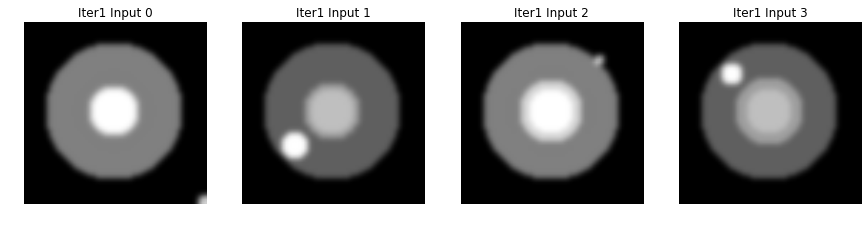

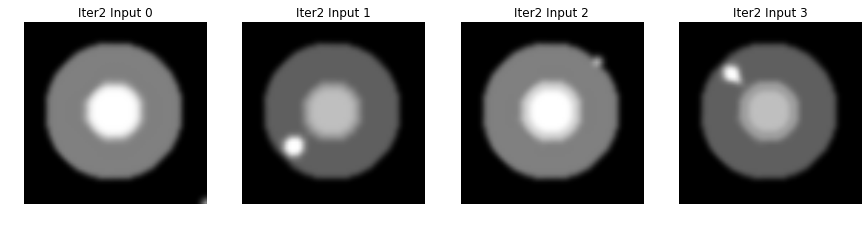

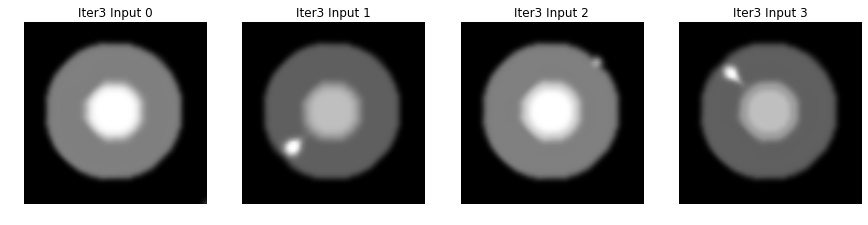

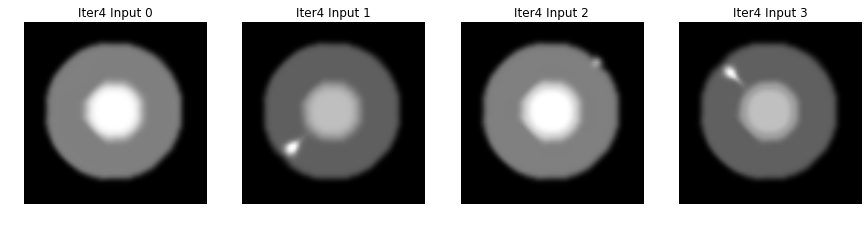

In [11]:
# main
NUM_OF_ITERATIONS = 4

COMPOSE_DVF = True

for i in range(NUM_OF_ITERATIONS):
    print 'iter'+str(i+1)
    runIteration(i+1)


In [12]:
def computeHealthyDeformations():
    #Validation & Comparison: register healthy simulation images to frechet mean
    healthyIm_names = [ \
     data_folder+'/healthySimu1.nrrd',
     data_folder+'/healthySimu2.nrrd',
     data_folder+'/healthySimu3.nrrd',
     data_folder+'/healthySimu4.nrrd']

    for i in range(num_of_data):
        fn = healthyIm_names[selection[i]]
        outputIm = data_folder+'/atlas-building/healthyDeformed_' + str(i)  + '.nrrd'
        outputDVF = data_folder+'/atlas-building/healthyDVF_' + str(i) +  '.nrrd'
    
        cmd = DemonsReg(EXE_BRAINSDemonWarp,reference_im_name,fn,outputIm, outputDVF)
    
        logFile = open(data_folder+'/atlas-building/healthy_'+ str(i)+'.log', 'w')

        process = subprocess.Popen(cmd, stdout = logFile, shell = True)
        process.wait()
        logFile.close()

#computeHealthyDeformations()

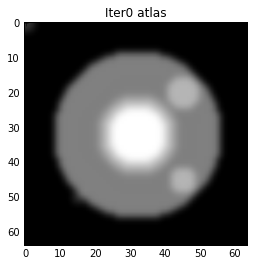

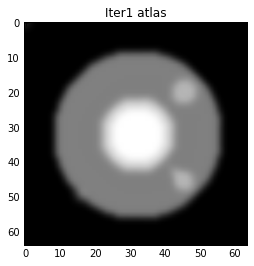

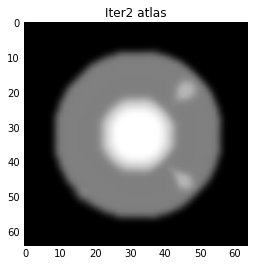

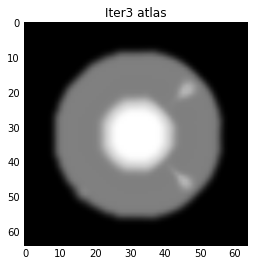

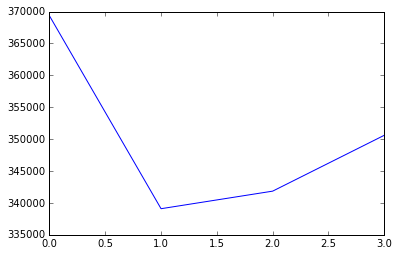

In [13]:
# check atlas similarities
MSE = zeros( NUM_OF_ITERATIONS)
for i in range(NUM_OF_ITERATIONS):
        atlasIm = result_folder+'/'+ 'Iter'+str(i+1) +'_atlas.nrrd'
        im = sitk.ReadImage(atlasIm) # image in SITK format
        im_array = sitk.GetArrayFromImage(im)
        MSE[i] = np.sum(np.square(im_ref_array - im_array))
        im= sitk.ReadImage(atlasIm) # image in SITK format
        im_array = sitk.GetArrayFromImage(im) # get numpy array
        figure()
        implot = plt.imshow(im_array[32,:,:],cm.gray)
        plt.title('Iter'+str(i)+ ' atlas')

    
figure()
plot(range(NUM_OF_ITERATIONS),MSE)